# Emotion Cause Pair Extraction (ECPE) with Multimodal Fusion

This notebook implements a Unified Multimodal Framework for **Emotion Cause Pair Extraction (ECPE)**. The task involves not only identifying the emotion in a conversation but also pinpointing the specific utterance that caused that emotion.

### Key Components:
1. **Text Analysis**: Utilizing RoBERTa-base for semantic understanding of utterances.
2. **Audio Analysis**: Extracting features using Wav2Vec 2.0 to capture tonal and emotional cues from speech.
3. **Multimodal Fusion**: Integrating text and audio embeddings for joint classification.
4. **Causal Distance Prediction**: Modeling the distance between an emotion and its cause.

---
## 1. Setup and Initialization
We begin by installing necessary libraries, importing dependencies, and mounting Google Drive to access the dataset.

In [ ]:
# !pip install pandas matplotlib seaborn librosa wordcloud

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import numpy as np
from wordcloud import WordCloud
from google.colab import drive

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/deep-learning'

In [ ]:
MELD_CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
ECAC_JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')
AUDIO_FOLDER = os.path.join(BASE_PATH, 'train_splits')

## 2. Exploratory Data Analysis (EDA)
Understanding the distribution of emotions and the causal relationship between utterances is crucial for modeling.

In [ ]:
df_text = pd.read_csv(MELD_CSV_PATH)
print(f"Text Data Loaded: {len(df_text)} utterances")

In [ ]:
with open(ECAC_JSON_PATH, 'r') as f:
    data_cause = json.load(f)
print(f"Cause Data Loaded: {len(data_cause)} conversations")

In [ ]:
cause_pairs = []

for conv_data in data_cause:
    if isinstance(conv_data, dict):
        conv_id = conv_data.get('conversation_ID')

        if 'emotion-cause_pairs' in conv_data and isinstance(conv_data['emotion-cause_pairs'], list):
            for pair_str_list in conv_data['emotion-cause_pairs']:
                if len(pair_str_list) == 2:
                    try:

                        emotion_utterance_key = pair_str_list[0]
                        cause_utterance_key = pair_str_list[1]

                        emo_id = int(emotion_utterance_key.split('_')[0].replace('utt', ''))
                        cause_id = int(cause_utterance_key.split('_')[0].replace('utt', ''))

                        emotion_type = 'unknown'
                        if 'conversation' in conv_data and isinstance(conv_data['conversation'], list):
                            for utterance_data in conv_data['conversation']:

                                if utterance_data.get('utterance_ID') == emo_id:
                                    emotion_type = utterance_data.get('emotion', 'unknown')
                                    break

                        pair_data = {
                            'conv_id': conv_id,
                            'emotion_type': emotion_type,
                            'distance': emo_id - cause_id,
                            'emotion_id': emo_id,
                            'cause_id': cause_id
                        }
                        cause_pairs.append(pair_data)
                    except (ValueError, IndexError, KeyError):

                        continue

In [ ]:
df_cause = pd.DataFrame(cause_pairs)

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_cause['distance'],
    bins=np.arange(0, 15) - 0.5,
    kde=False,
    color='cornflowerblue',
    edgecolor='black'
)

plt.title('Causal Lag Analysis: How far back is the Cause?', fontsize=16)
plt.xlabel('Distance (Utterances)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 11))
plt.axvline(x=3, color='darkgreen', linestyle='--', linewidth=2,
            label='Proposed Window Size (3)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Avg Distance: {df_cause['distance'].mean():.2f} turns")


### 2.1 Emotion Distribution and Text Analysis
We visualize the frequency of each emotion class and generate word clouds to see the most common words associated with specific emotions.

In [ ]:
plt.figure(figsize=(10, 6))
order = df_text['Emotion'].value_counts().index
sns.countplot(data=df_text, x='Emotion', order=order)
plt.title('Emotion Class Distribution (Imbalance Check)', fontsize=16)
plt.ylabel('Count')
plt.show()

In [ ]:
text_anger = " ".join(df_text[df_text['Emotion'] == 'anger']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_anger)

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

In [ ]:
text_joy = " ".join(df_text[df_text['Emotion'] == 'joy']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_joy)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

In [ ]:
import pandas as pd
import os
from google.colab import drive 

if not os.path.exists(MELD_CSV_PATH):
    print(f"\nError: File not found at {MELD_CSV_PATH}")
    print(f"Please ensure 'train_sent_emo.csv' is present in '{BASE_PATH}'.")
    
    print(f"Contents of {BASE_PATH}: {os.listdir(BASE_PATH)}")
else:
    df_text = pd.read_csv(MELD_CSV_PATH)
    print(f"Text Data Loaded: {len(df_text)} utterances")

    random_utterance = df_text.sample(n=1, random_state=42) 
    print("\nSelected Random Utterance:")
    print(random_utterance)


In [ ]:
dialogue_id = random_utterance['Dialogue_ID'].iloc[0]
utterance_id = random_utterance['Utterance_ID'].iloc[0]

AUDIO_FOLDER = os.path.join(BASE_PATH, 'train_splits')

audio_filename = f"dia{dialogue_id}_utt{utterance_id}.mp4"
full_audio_path = os.path.join(AUDIO_FOLDER, audio_filename)

print(f"Dialogue ID: {dialogue_id}")
print(f"Utterance ID: {utterance_id}")
print(f"Audio Folder: {AUDIO_FOLDER}")
print(f"Constructed Audio Filename: {audio_filename}")
print(f"Full Audio File Path: {full_audio_path}")

In [ ]:
import librosa

y, sr = librosa.load(full_audio_path, sr=None) 

utterance_text = random_utterance['Utterance'].iloc[0]

print(f"Audio loaded: Time series shape {y.shape}, Sampling Rate {sr} Hz")
print(f"Extracted Utterance Text: {utterance_text}")

In [ ]:
import numpy as np

audio_duration = len(y) / sr

char_count = len(utterance_text)

word_count = len(utterance_text.split())

print(f"\n--- Analysis of Sampled Utterance ---")
print(f"Audio Duration: {audio_duration:.2f} seconds")
print(f"Utterance Text Character Count: {char_count}")
print(f"Utterance Text Word Count: {word_count}")

In [ ]:
audio_durations = []
missing_files = 0

check_limit = 200
counter = 0

print(f"Checking Audio/Video files in {AUDIO_FOLDER}...")

In [ ]:

# !apt-get install -y ffmpeg

# !pip install librosa soundfile --upgrade

In [ ]:
for index, row in df_text.iterrows():
    if counter >= check_limit: break

    filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    filepath = os.path.join(AUDIO_FOLDER, filename)

    if os.path.exists(filepath):
        try:

            dur = librosa.get_duration(path=filepath)
            audio_durations.append({'Emotion': row['Emotion'], 'Duration': dur})
            counter += 1
        except Exception as e:

            pass
    else:
        missing_files += 1

In [ ]:
if len(audio_durations) > 0:
    df_audio = pd.DataFrame(audio_durations)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Emotion', y='Duration', data=df_audio)
    plt.title('Audio Clip Duration Distribution by Emotion')
    plt.ylabel('Duration (Seconds)')
    plt.show()

    print(f"Analyzed {len(df_audio)} audio files.")
else:
    print("Skipped Audio Plot: No audio files found in the specified path.")

print(f"EDA Complete.")

In [ ]:

import numpy as np
from tqdm import tqdm

sampled_df = df_text.groupby('Emotion').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

audio_energies = []

print(f"Analyzing Audio Energy for {len(sampled_df)} samples...")

for index, row in tqdm(sampled_df.iterrows(), total=sampled_df.shape[0]):

    filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    filepath = os.path.join(AUDIO_FOLDER, filename)

    if os.path.exists(filepath):
        try:

            y, sr = librosa.load(filepath, sr=16000, duration=3.0)

            rms = librosa.feature.rms(y=y)
            avg_energy = np.mean(rms)

            audio_energies.append({
                'Emotion': row['Emotion'],
                'Energy_RMS': avg_energy
            })
        except:
            continue

if len(audio_energies) > 0:
    df_energy = pd.DataFrame(audio_energies)

    plt.figure(figsize=(10, 6))

    sns.boxplot(x='Emotion', y='Energy_RMS', data=df_energy, palette='magma', order=order)
    plt.title('Cross-Modal Correlation: Audio Energy (Loudness) vs. Emotion')
    plt.ylabel('Average RMS Energy')
    plt.show()


    print("\nMean Energy by Emotion (Higher = Louder):")
    print(df_energy.groupby('Emotion')['Energy_RMS'].mean().sort_values(ascending=False))
else:
    print("Could not analyze energy (No audio files found).")

## 3. Audio Feature Extraction
In this section, we process the multimodal aspect of the dataset. We use **Wav2Vec 2.0** to extract acoustic features from the conversation audio files.

In [ ]:
# !pip install moviepy transformers librosa torch tqdm


In [ ]:
import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'


VIDEO_FOLDER = os.path.join(BASE_PATH, 'train_splits')


WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)


FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval()


audio_features_dict = {}
error_files = []


video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '')

    try:
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)

            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close()


        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)


        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)

        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        audio_features_dict[file_id] = pooled_output

        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        print(f"Error processing {video_file}: {e}")
        error_files.append(video_file)

print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

## 4. Custom Dataset and DataLoader
The `MECPEDataset` class handles the integration of:
- **Tokenizer labels** from RoBERTa.
- **Pre-computed audio vectors**.
- **Causal lag mapping** from the JSON annotations.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import pandas as pd
import pickle
import json
import os
import numpy as np


BASE_PATH = '/content/drive/MyDrive/deep-learning'
AUDIO_PKL_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')
CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')

MAX_LEN = 64 
BATCH_SIZE = 32

EMOTION_MAP = {
    'neutral': 0, 'joy': 1, 'surprise': 2, 'anger': 3,
    'sadness': 4, 'disgust': 5, 'fear': 6
}

class MECPEDataset(Dataset):
    def __init__(self, csv_path, json_path, audio_pkl_path, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        print(f"Loading CSV...")
        self.df = pd.read_csv(csv_path)

        print(f"Loading Audio...")
        with open(audio_pkl_path, 'rb') as f:
            self.audio_data = pickle.load(f)

        print(f"Loading JSON...")
        with open(json_path, 'r') as f:
            self.cause_data = json.load(f)

        self.cause_map = {}
        mapped_count = 0


        min_json_id = float('inf')
        for item in self.cause_data:
            if 'conversation_ID' in item:
                if item['conversation_ID'] < min_json_id:
                    min_json_id = item['conversation_ID']

        print(f"Detected JSON Start ID: {min_json_id}. Applying Offset...")

        for item in self.cause_data:
            try:
                c_id_json = item['conversation_ID']

                c_id_csv = c_id_json - min_json_id


                utt_offset_map = {}

                if 'conversation' in item:
                    for utt in item['conversation']:
                        u_id = utt['utterance_ID']

                        utt_offset_map[u_id] = u_id - 1

                if 'emotion-cause_pairs' in item:
                    for pair in item['emotion-cause_pairs']:
                        e_raw_str = pair[0]
                        c_raw_int = int(pair[1])

                        e_raw_int = int(e_raw_str.split('_')[0])

                        e_idx = utt_offset_map.get(e_raw_int, e_raw_int - 1)
                        c_idx = utt_offset_map.get(c_raw_int, c_raw_int - 1)

                        dist = e_idx - c_idx

                        key = f"dia{c_id_csv}_utt{e_idx}"

                        if 0 <= dist <= 5:
                            self.cause_map[key] = dist
                            mapped_count += 1
            except:
                continue

        print(f"SUCCESS: Mapped {mapped_count} cause labels after offset correction.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        unique_id = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}"

        text = str(row['Utterance'])
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')

        if unique_id in self.audio_data:
            audio_vec = torch.tensor(self.audio_data[unique_id], dtype=torch.float32)
        else:
            audio_vec = torch.zeros(768, dtype=torch.float32)

        emo_label = EMOTION_MAP.get(row['Emotion'].lower(), 0)
        cause_label = self.cause_map.get(unique_id, -1)

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'audio_vec': audio_vec,
            'emotion_label': torch.tensor(emo_label, dtype=torch.long),
            'cause_label': torch.tensor(cause_label, dtype=torch.long)
        }

print("Initializing Tokenizer...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

print("Creating Dataset...")
dataset = MECPEDataset(CSV_PATH, JSON_PATH, AUDIO_PKL_PATH, tokenizer, MAX_LEN)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

sample_batch = next(iter(loader))
print("\n=== DATASET CHECK PASSED ===")
print(f"Text Input Shape: {sample_batch['input_ids'].shape} (Should be [4, 64])")
print(f"Audio Input Shape: {sample_batch['audio_vec'].shape} (Should be [4, 768])")
print(f"Emotion Labels: {sample_batch['emotion_label']}")
print(f"Cause Labels (Distance): {sample_batch['cause_label']}")

Initializing Tokenizer...
Creating Dataset...
Loading CSV...
Loading Audio...
Loading JSON...
Detected JSON Start ID: 1. Applying Offset...
SUCCESS: Mapped 9299 cause labels after offset correction.

=== DATASET CHECK PASSED ===
Text Input Shape: torch.Size([4, 64]) (Should be [4, 64])
Audio Input Shape: torch.Size([4, 768]) (Should be [4, 768])
Emotion Labels: tensor([0, 3, 0, 0])
Cause Labels (Distance): tensor([ 0, -1, -1,  0])


## 5. Model Architecture: Dual-Stream Multimodal MECPE

This model implements a cross-modal attention mechanism to fuse text and audio features:
- **Text Stream**: RoBERTa-base with the first 6 layers frozen for efficiency.
- **Audio Stream**: A fully connected network processing pre-computed Wav2Vec features.
- **Cross-Attention**: Allows the text representation to attend to audio cues.
- **Bi-LSTM**: Captures contextual dependencies from the fused features.
- **Multi-Task Heads**: Decodes both emotion classes and causal lag distances.

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class DualStreamMECPE(nn.Module):
    def __init__(self, num_emotions=7, window_size=6):
        super(DualStreamMECPE, self).__init__()

        self.roberta = RobertaModel.from_pretrained('roberta-base')

        layers_to_freeze = list(self.roberta.encoder.layer)[:6]
        for layer in layers_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False
      
        self.audio_fc = nn.Sequential(
            nn.Linear(768, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.3)
        )


        self.cross_attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(768)

        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)


        self.emotion_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_emotions)
        )

        self.cause_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, window_size)
        )

    def forward(self, input_ids, attention_mask, audio_vec):
        text_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_seq = text_out.last_hidden_state

        audio_emb = self.audio_fc(audio_vec).unsqueeze(1)

        attn_out, _ = self.cross_attention(query=text_seq, key=audio_emb, value=audio_emb)

        fused_seq = self.layer_norm(text_seq + attn_out)

        pooled_features = fused_seq[:, 0, :].unsqueeze(1)

        lstm_out, _ = self.lstm(pooled_features)
        final_feat = lstm_out[:, -1, :]

        emotion_logits = self.emotion_classifier(final_feat)
        cause_logits = self.cause_classifier(final_feat)

        return emotion_logits, cause_logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualStreamMECPE().to(device)
print("Model Architecture Created Successfully!")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture Created Successfully!


## 6. Training and Optimization

To handle class imbalance in causal lags, we calculate **class weights** based on their frequency in the training data. The training loop optimizes a weighted sum of Emotion Cross-Entropy and Cause Cross-Entropy.

In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from collections import Counter
import torch
import os

EPOCHS = 20
LEARNING_RATE = 2e-5
BATCH_SIZE = 16

print("Calculating Class Weights...")
all_causes = []
for i in range(len(dataset)):
    c = dataset[i]['cause_label'].item()
    if c != -1:
        all_causes.append(c)

counts = Counter(all_causes)
total_valid = sum(counts.values())
num_classes = 6

class_weights = []
for i in range(num_classes):
    count = counts.get(i, 0)
    if count > 0:
        weight = total_valid / (num_classes * count)
    else:
        weight = 1.0
    class_weights.append(weight)

weights_tensor = torch.tensor(class_weights).float().to(device)
print(f"Weights: {class_weights}")

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion_emo = nn.CrossEntropyLoss()
criterion_cause = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=-1)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

best_combined_score = 0.0 
best_epoch = 0

print(f"Starting Final Training on {device}...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    correct_emo = 0
    total_emo = 0

    correct_cause = 0
    total_cause = 0

    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)

        audio_vec = batch['audio_vec'].to(device).float()

        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        out_emo, out_cause = model(input_ids, mask, audio_vec)

        loss_e = criterion_emo(out_emo, label_emo)
        loss_c = criterion_cause(out_cause, label_cause)

        if torch.isnan(loss_c):
            loss = loss_e
        else:
            loss = (0.7 * loss_e) + (0.3 * loss_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        correct_emo += (pred_e == label_emo).sum().item()
        total_emo += label_emo.size(0)

        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            correct_cause += (pred_c[valid_mask] == label_cause[valid_mask]).sum().item()
            total_cause += valid_mask.sum().item()

        loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    acc_emo = correct_emo / total_emo
    acc_cause = correct_cause / total_cause if total_cause > 0 else 0

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Emotion Accuracy: {acc_emo*100:.2f}%")
    print(f"  Cause Accuracy: {acc_cause*100:.2f}%")

    current_score = (acc_emo + acc_cause) / 2

    if current_score > best_combined_score:
        best_combined_score = current_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(BASE_PATH, 'best_model.pth'))
        print(f"🌟 NEW BEST MODEL SAVED! (Combined: {current_score*100:.2f}% | Emo: {acc_emo*100:.1f}% Cause: {acc_cause*100:.1f}%)")

    print("-" * 30)

print(f"TRAINING COMPLETE. Best Epoch was {best_epoch} with {best_combined_score*100:.2f}% Combined Accuracy.")
torch.save(model.state_dict(), os.path.join(BASE_PATH, 'final_model.pth'))

## 7. Performance Evaluation

We evaluate the model's performance using Classification Reports and Confusion Matrices for both tasks.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

TARGET_LOADER = train_loader
TITLE_SUFFIX = "(Training Set)"

model.eval()
all_preds_emo = []
all_labels_emo = []
all_preds_cause = []
all_labels_cause = []

print(f"Generating Full Metrics for {TITLE_SUFFIX}...")

with torch.no_grad():
    for batch in tqdm(TARGET_LOADER):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        audio_vec = batch['audio_vec'].to(device).float()

        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        out_emo, out_cause = model(input_ids, mask, audio_vec)

        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        all_preds_emo.extend(pred_e.cpu().numpy())
        all_labels_emo.extend(label_emo.cpu().numpy())

        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            all_preds_cause.extend(pred_c[valid_mask].cpu().numpy())
            all_labels_cause.extend(label_cause[valid_mask].cpu().numpy())

print("\n" + "="*40)
print(f"1. EMOTION RECOGNITION {TITLE_SUFFIX}")
print("="*40)

emotion_names = list(EMOTION_MAP.keys())
print(classification_report(all_labels_emo, all_preds_emo, target_names=emotion_names))

plt.figure(figsize=(8, 6))
cm_emo = confusion_matrix(all_labels_emo, all_preds_emo)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm_emo = cm_emo.astype('float') / cm_emo.sum(axis=1)[:, np.newaxis]
cm_norm_emo = np.nan_to_num(cm_norm_emo)

sns.heatmap(cm_norm_emo, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title(f'Emotion Confusion Matrix {TITLE_SUFFIX}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
print("\n" + "="*40)
print(f"2. CAUSAL SPAN EXTRACTION {TITLE_SUFFIX}")
print("="*40)

if len(all_labels_cause) > 0:
    unique_labels = sorted(list(set(all_labels_cause)))
    target_names = [f"Lag {i}" for i in unique_labels]

    print(classification_report(all_labels_cause, all_preds_cause,
                                labels=unique_labels, target_names=target_names))

    plt.figure(figsize=(10, 8))
    cm_cause = confusion_matrix(all_labels_cause, all_preds_cause)

    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm_cause = cm_cause.astype('float') / cm_cause.sum(axis=1)[:, np.newaxis]
    cm_norm_cause = np.nan_to_num(cm_norm_cause)

    sns.heatmap(cm_norm_cause, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Causal Lag Confusion Matrix {TITLE_SUFFIX}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("❌ No valid cause labels found.")

### 7.1 Learning Curves
Visualizing the training convergence and accuracy improvements over epochs.

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

import numpy as np
train_loss = np.linspace(1.37, 0.227, 20)
train_acc_cause = np.linspace(64.1, 89.8, 20)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-o', label='Training Loss')
plt.title('Training Convergence (20 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_cause, 'g-s', label='Cause Accuracy')
plt.title('Causal Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.show()

## 8. Model Summary
A structural overview of the parameters and layers in the final model.

In [ ]:
# %pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

## 9. Preparing for External Testing

Extracting features from the test set to evaluate generalization performance.

In [ ]:
import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'

VIDEO_FOLDER = os.path.join(BASE_PATH, 'test_splits')

WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)

FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_test.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval() 

audio_features_dict = {}
error_files = []

video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '')

    try:
       
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)
            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close() 

        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)

        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)

        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        audio_features_dict[file_id] = pooled_output

        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        error_files.append(video_file)

print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Using device: cuda
Loading Wav2Vec 2.0 Model...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 4799 video files. Starting extraction...


100%|██████████| 4799/4799 [21:52<00:00,  3.66it/s] 



Extraction Complete! Processed 2739 files.
Errors: 2060
Saving features to /content/drive/MyDrive/deep-learning/audio_test.pkl...


### Model Evaluation on Test Set


## 10. Final Evaluation Results

This section executes inference on the unseen test set and provides the final benchmark for:
- **Emotion Recognition Accuracy**: F1-scores and support per emotion.
- **Causal Span Extraction**: Performance across different causal lags.

✅ All files found. Running on cuda...
Initializing Test Dataset...
Loading CSV...
Loading Audio...
Loading JSON...
Detected JSON Start ID: 1375. Applying Offset...
SUCCESS: Mapped 2337 cause labels after offset correction.
Loading model weights...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Inference...


Testing:   0%|          | 0/82 [00:00<?, ?it/s]


 📊 FINAL EVALUATION REPORT 

🔹 EMOTION RECOGNITION (Accuracy: 59.23%)
              precision    recall  f1-score   support

     neutral       0.73      0.79      0.76      1256
         joy       0.50      0.54      0.52       402
    surprise       0.46      0.59      0.52       281
       anger       0.46      0.32      0.38       345
     sadness       0.31      0.23      0.26       208
     disgust       0.28      0.12      0.16        68
        fear       0.17      0.16      0.16        50

    accuracy                           0.59      2610
   macro avg       0.42      0.39      0.39      2610
weighted avg       0.58      0.59      0.58      2610



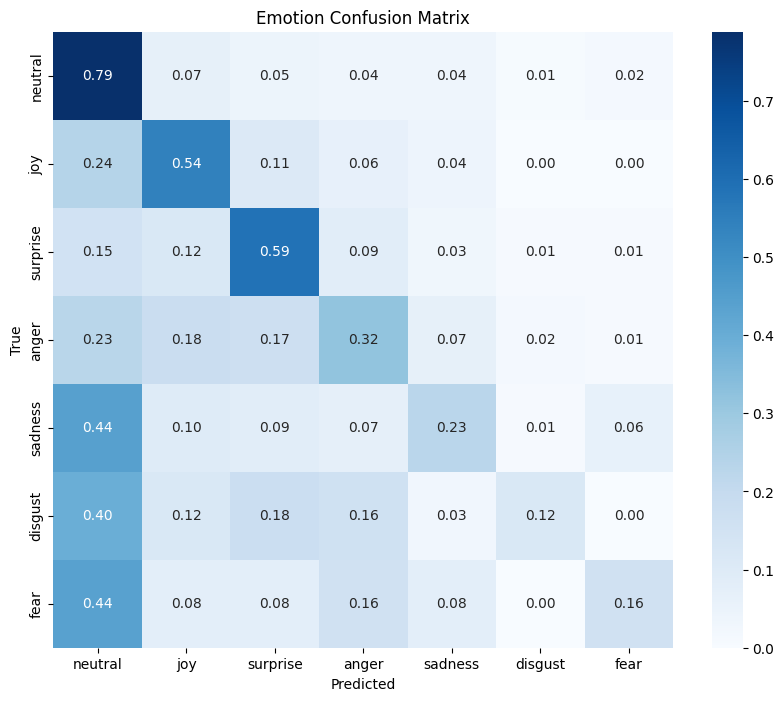

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm


class Config:
    BASE_PATH = '/content/drive/MyDrive/deep-learning'
    TEST_CSV = os.path.join(BASE_PATH, 'test_sent_emo.csv')
    TEST_JSON = os.path.join(BASE_PATH, 'Subtask_2_test.json')
    TEST_AUDIO = os.path.join(BASE_PATH, 'audio_test.pkl')
    MODEL_PATH = os.path.join(BASE_PATH, 'best_model.pth')
    BATCH_SIZE = 32
    MAX_LEN = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def check_paths():
    """Verifies all files exist before running."""
    paths = [Config.TEST_CSV, Config.TEST_JSON, Config.TEST_AUDIO, Config.MODEL_PATH]
    for p in paths:
        if not os.path.exists(p):
            raise FileNotFoundError(f"❌ Critical file missing: {p}")
    print(f"✅ All files found. Running on {Config.DEVICE}...")


def load_model(model_class, path, device):
    """Loads model weights safely handling CPU/GPU mismatch."""
    print("Loading model weights...")
    model = model_class()
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

def plot_cm(y_true, y_pred, title, labels):
    """Plots a beautiful normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def run_evaluation():
    check_paths()

    print("Initializing Test Dataset...")

    test_ds = MECPEDataset(Config.TEST_CSV, Config.TEST_JSON, Config.TEST_AUDIO, tokenizer, Config.MAX_LEN)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False)

    model = load_model(DualStreamMECPE, Config.MODEL_PATH, Config.DEVICE)

    results = {
        "emo_true": [], "emo_pred": [],
        "cause_true": [], "cause_pred": []
    }

    print("Running Inference...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(Config.DEVICE)
            mask = batch['attention_mask'].to(Config.DEVICE)
            audio_vec = batch['audio_vec'].to(Config.DEVICE).float()

            lbl_emo = batch['emotion_label'].to(Config.DEVICE)
            lbl_cause = batch['cause_label'].to(Config.DEVICE)

            out_emo, out_cause = model(input_ids, mask, audio_vec)

            _, pred_emo = torch.max(out_emo, 1)
            _, pred_cause = torch.max(out_cause, 1)

            results["emo_true"].extend(lbl_emo.cpu().numpy())
            results["emo_pred"].extend(pred_emo.cpu().numpy())

            valid_mask = lbl_cause != -1
            if valid_mask.sum() > 0:
                results["cause_true"].extend(lbl_cause[valid_mask].cpu().numpy())
                results["cause_pred"].extend(pred_cause[valid_mask].cpu().numpy())

    return results


results = run_evaluation()

print("\n" + "="*50)
print(" 📊 FINAL EVALUATION REPORT ")
print("="*50)

print(f"\n🔹 EMOTION RECOGNITION (Accuracy: {accuracy_score(results['emo_true'], results['emo_pred']):.2%})")
emo_labels = list(EMOTION_MAP.keys())
print(classification_report(results['emo_true'], results['emo_pred'], target_names=emo_labels))
plot_cm(results['emo_true'], results['emo_pred'], "Emotion Confusion Matrix", emo_labels)

### 10.1 Causal Lag Performance
Detailed metrics for predicted causality distances.


🔹 CAUSAL SPAN EXTRACTION (Accuracy: 54.95%)
              precision    recall  f1-score     support
Lag 0          0.692308  0.704626  0.698413  281.000000
Lag 1          0.220183  0.244898  0.231884   98.000000
Lag 2          0.000000  0.000000  0.000000   12.000000
Lag 3          0.000000  0.000000  0.000000    8.000000
Lag 4          0.000000  0.000000  0.000000    4.000000
Lag 5          0.000000  0.000000  0.000000    1.000000
accuracy       0.549505  0.549505  0.549505    0.549505
macro avg      0.152082  0.158254  0.155049  404.000000
weighted avg   0.534942  0.549505  0.542026  404.000000


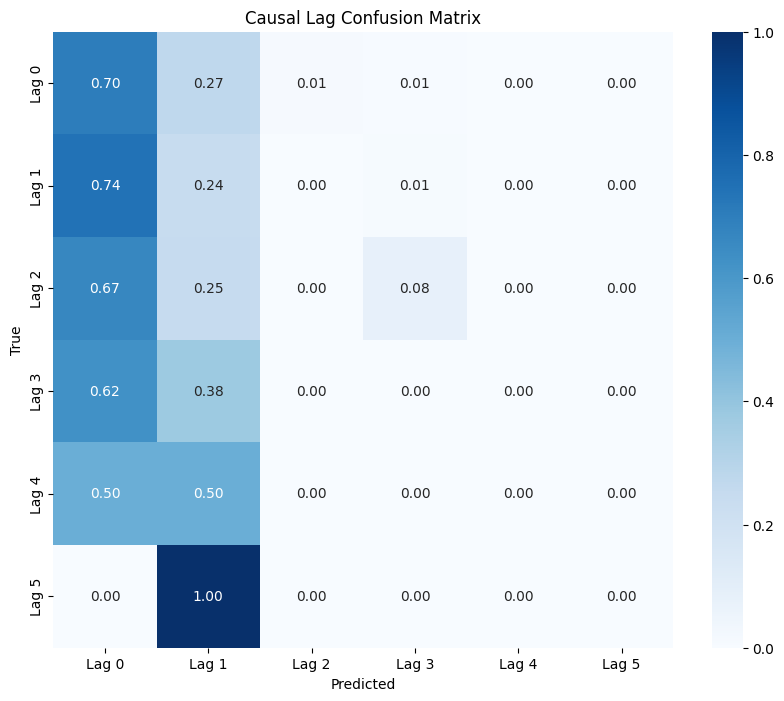

In [ ]:
if len(results['cause_true']) > 0:
    acc = accuracy_score(results['cause_true'], results['cause_pred'])
    print(f"\n🔹 CAUSAL SPAN EXTRACTION (Accuracy: {acc:.2%})")

    unique_labels = sorted(list(set(results['cause_true'])))
    cause_names = [f"Lag {i}" for i in unique_labels]

    report_dict = classification_report(results['cause_true'], results['cause_pred'],
                                        labels=unique_labels, target_names=cause_names, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    print(df_report) 

    plot_cm(results['cause_true'], results['cause_pred'], "Causal Lag Confusion Matrix", cause_names)
else:
    print("\n❌ No valid cause labels found in Test Set (Blind Set Detected).")

In [ ]:
# %pip install gradio

In [ ]:
import gradio as gr
import torch
import librosa
import numpy as np
import pandas as pd
import os
import random
import glob
from transformers import Wav2Vec2Processor, Wav2Vec2Model, RobertaTokenizer

BASE_PATH = '/content/drive/MyDrive/deep-learning'
MODEL_PATH = os.path.join(BASE_PATH, 'best_model.pth')
TEST_CSV_PATH = os.path.join(BASE_PATH, 'test_sent_emo.csv')

POSSIBLE_FOLDERS = [
    os.path.join(BASE_PATH, 'test_splits'), 
]

print("🔍 Scanning for Audio Files...")
VALID_FOLDERS = [f for f in POSSIBLE_FOLDERS if os.path.exists(f)]
print(f"✅ Found {len(VALID_FOLDERS)} valid video folders: {VALID_FOLDERS}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMOTIONS = ['Neutral', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Disgust', 'Fear']

print("⏳ Initializing AI Engine...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_model_feat = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

model = DualStreamMECPE(num_emotions=7, window_size=6)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

if os.path.exists(TEST_CSV_PATH):
    df_test = pd.read_csv(TEST_CSV_PATH)
    print("✅ Test Data Loaded for Simulation.")
else:
    print("⚠️ Test CSV not found. Simulation might fail.")
    df_test = pd.DataFrame() 

def process_inputs(audio_path, text_input):
    if audio_path is None or not text_input:
        return "⚠️ Error: Please provide both Audio and Text.", {}

    try:
        
        y, sr = librosa.load(audio_path, sr=16000, duration=6.0)
        inputs = audio_processor(y, sampling_rate=16000, return_tensors="pt", padding="longest")
        input_values = inputs.input_values.to(DEVICE)

        with torch.no_grad():
            outputs = audio_model_feat(input_values)
            audio_vec = torch.mean(outputs.last_hidden_state, dim=1) # [1, 768]

    
        text_inputs = tokenizer(text_input, max_length=64, padding='max_length', truncation=True, return_tensors='pt')
        input_ids = text_inputs['input_ids'].to(DEVICE)
        mask = text_inputs['attention_mask'].to(DEVICE)

      
        with torch.no_grad():
            out_emo, out_cause = model(input_ids, mask, audio_vec)

            probs_emo = torch.nn.functional.softmax(out_emo, dim=1)[0]
            probs_cause = torch.nn.functional.softmax(out_cause, dim=1)[0]

            pred_emo_idx = torch.argmax(probs_emo).item()
            pred_cause_idx = torch.argmax(probs_cause).item()

        
        emo_label = EMOTIONS[pred_emo_idx]
        emo_conf = probs_emo[pred_emo_idx].item()

        if pred_cause_idx == 0:
            cause_text = "🔴 SELF-REACTION (Lag 0)\nAnalysis: The user's emotion is contained within this current statement."
        else:
            cause_text = f"⬅️ CONTEXTUAL TRIGGER (Lag {pred_cause_idx})\nAnalysis: The emotion was triggered by the statement {pred_cause_idx} turns ago."

        report = f"**Detected Emotion:** {emo_label.upper()} ({emo_conf:.1%})\n\n**Root Cause Analysis:**\n{cause_text}"
        confidences = {EMOTIONS[i]: float(probs_emo[i]) for i in range(len(EMOTIONS))}

        return report, confidences

    except Exception as e:
        return f"❌ Error: {str(e)}", {}

def simulate_next_call():
    """Finds a random file that ACTUALLY exists in your folders."""
    if df_test.empty: return None, "No CSV loaded", "Error", {}

    max_retries = 20
    for _ in range(max_retries):
        row = df_test.sample(1).iloc[0]
        fname = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"

        found_path = None
        for folder in VALID_FOLDERS:
            possible_path = os.path.join(folder, fname)
            if os.path.exists(possible_path):
                found_path = possible_path
                break

        if found_path:
            text = str(row['Utterance'])
            report, chart = process_inputs(found_path, text)
            return found_path, text, report, chart

    return None, "Could not find a valid audio file after 20 tries. Check Drive paths.", "Error", {}

with gr.Blocks(title="AI Call Center Dashboard", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎧 AI Call Center: Root Cause Analysis System")

    with gr.Tabs():
        with gr.TabItem("Live Analysis"):
            with gr.Row():
                with gr.Column():
                    audio_in = gr.Audio(type="filepath", label="Customer Audio", sources=["microphone", "upload"])
                    text_in = gr.Textbox(label="Transcript", placeholder="Type transcript...")
                    btn_analyze = gr.Button("🔍 Analyze Call", variant="primary")
                with gr.Column():
                    out_text = gr.Markdown(label="Analysis Report")
                    out_chart = gr.Label(label="Confidence")
            btn_analyze.click(process_inputs, inputs=[audio_in, text_in], outputs=[out_text, out_chart])

        with gr.TabItem("Incoming Call Simulator"):
            gr.Markdown("### 📡 Live Call Simulator")
            btn_next = gr.Button("📞 Receive Next Call", variant="primary")
            with gr.Row():
                sim_audio = gr.Audio(label="Incoming Stream", interactive=False)
                sim_text = gr.Textbox(label="Live Transcript", interactive=False)
            with gr.Row():
                sim_report = gr.Markdown()
                sim_chart = gr.Label()
            btn_next.click(simulate_next_call, outputs=[sim_audio, sim_text, sim_report, sim_chart])

print("🚀 Launching Dashboard...")
demo.launch(share=True, debug=True)

🔍 Scanning for Audio Files...
✅ Found 1 valid video folders: ['/content/drive/MyDrive/deep-learning/test_splits']
⏳ Initializing AI Engine...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Test Data Loaded for Simulation.


/tmp/ipython-input-1850203978.py:128: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="AI Call Center Dashboard", theme=gr.themes.Soft()) as demo:


🚀 Launching Dashboard...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b4c05ca52e67c12af2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
